## Reading and writing rasters using `rasterio`

In [15]:
import sys
sys.path.insert(0, 'D:/ATLData/Documents/GitHub/flopy')
sys.path.insert(0, '/Users/aleaf/Documents/GitHub/flopy3')
from rasterio import Affine
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from GISio import arc_ascii

%matplotlib inline

In [16]:
example_dem = '../Hannah_example/buffhaz_dem_30m_clip.txt'

### read in an Arc-ascii grid

first read in the header

In [17]:
meta = {}
with open(example_dem) as input:
    for i in range(6):
        line = next(input).strip().split()
        meta[line[0]] = line[1]
meta

{'NODATA_value': '-9999',
 'cellsize': '30',
 'ncols': '1449',
 'nrows': '1197',
 'xllcorner': '546816.4',
 'yllcorner': '2682014.72'}

#### read the data to a numpy array

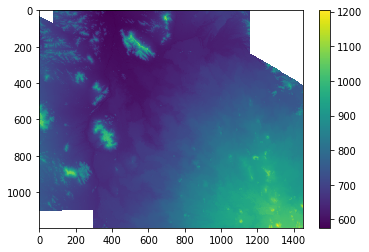

In [18]:
dem = np.loadtxt(example_dem, skiprows=6)
dem[dem == float(meta['NODATA_value'])] = np.nan
# make a plot, masking the no data values
plt.imshow(dem)
plt.colorbar()

### Write a Geotiff using `rasterio`

#### create an `Affine` object to position grid in space using the info from the arc-ascii grid

In [19]:
cellsize = float(meta['cellsize'])
xul = float(meta['xllcorner']) # since the grid is unrotated
yul = float(meta['yllcorner']) + cellsize * dem.shape[1]
trans = Affine(cellsize, 0., xul, 
               0., -cellsize, yul)

#### set up other raster properties and write a numpy array to Band 1

we know that the CRS is UTM north zone 37. Look up an EPSG code on spatialreference.org to make it easier to specify  
for example: http://spatialreference.org/ref/epsg/wgs-84-utm-zone-37n/  

In [20]:
properties = {'count': 1, # number of bands
              'crs': '+init=epsg:32637', # coordinate system
              'transform': trans,
              'width': dem.shape[1],
              'height': dem.shape[0],
              'driver': 'GTiff',
              'dtype': np.float64,
              'nodata': float(meta['NODATA_value'])
             }

with rasterio.open('data/dem.tif', 'w', **properties) as dst:
    dst.write(dem, 1)

#### read the raster back in to check that it was written properly

In [21]:
with rasterio.open('data/dem.tif') as src:
    dem = src.read(1) # read band 1 to numpy array

In [22]:
src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32637'}),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 1197,
 'nodata': -9999.0,
 'transform': Affine(30.0, 0.0, 546816.4,
       0.0, -30.0, 2725484.72),
 'width': 1449}

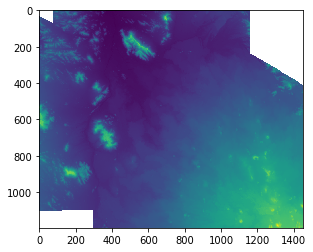

In [23]:
plt.imshow(dem)

### Write an Arc Ascii grid file

In [24]:
arc_ascii(dem, 'data/dem.asc', 
          xll=float(meta['xllcorner']), 
          yll=float(meta['yllcorner']), 
          cellsize=cellsize, fmt='%.2f')

wrote data/dem.asc
